# Momentum Trading Based on Neural Network Models

### Data Preprocessing

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

C:\Users\DR\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
from os import listdir
from os.path import isfile, join
dates=listdir('C:/Users/DR/Desktop/FE/Spring 2019/Algo/data')

In [3]:
stocks=listdir('C:/Users/DR/Desktop/FE/Spring 2019/Algo/data/'+dates[0])

In [4]:
f=open('labels.txt','w')
for name in stocks:
    f.write(name[6:-4].upper()+'\n')    
f.close()

Indicator Functions

In [6]:
#Exponential Moving Average
def EMA(C):
    c = 1-1.0/5.0
    EMA=[C[0]]
    for i in range(1,len(C)):
        close =C[i]  
        ema = EMA[-1]*c+close*(1-c)
        EMA.append(ema)
    return np.array(EMA)

In [7]:
#Moving Average Convergence Divergence
def MACD(C):
    a=1-2.0/11.0
    b=1-2.0/31.0
    ema_a = C[0]
    ema_b = C[0]
    EMA_a = [ema_a]
    EMA_b= [ema_b]
    for i in range(1,len(C)):
        close = C[i]  
        ema_a = EMA_a[-1]*a+close*(1-a)
        ema_b = EMA_b[-1]*b+close*(1-b)
        EMA_a.append(ema_a)
        EMA_b.append(ema_b)
    DIFF = np.array(EMA_a)-np.array(EMA_b)
    DEA=[DIFF[0]]
    c = 1-1.0/5.0
    for i in range(1,len(DIFF)):
        close =DIFF[i]  
        dea = DEA[-1]*c+close*(1-c)
        DEA.append(dea)
    MACD = 2*(DIFF-DEA)
    return np.array(MACD)

In [8]:
#Relative Strength Index
def RSI(C):
    hist=14
    RSI=[0]
    Ret=np.diff(C)/C[:-1]
    for i in range(1,len(C)):
        
        p=Ret[max(0,i-hist+1):i+1]
        pu=p[p>0]
        pd=p[p<0]

        if len(pd)==0:
            RSI.append(100)
        elif len(pu)==0:
            RSI.append(0)
        else:
            su=abs(np.mean(pu))
            sd=abs(np.mean(pd))
            rs=(su)/(sd)

            rsi=100-100.0/(1+rs)

            RSI.append(rsi)
            #print rsi
    RSI=np.array(RSI)
    return RSI

In [9]:
#Stochastic Oscillator
def SO(C,H,L):
    SO=[]
    hist=14
    for i in range(len(C)):

        c=C[i]
        h=max(H[max(0,i-hist+1):i+1])
        l=min(L[max(0,i-hist+1):i+1])
        k=100*(c-l)/(h-l)
        SO.append(k)
    SO=np.array(SO)
    return SO

In [10]:
#On Balance Volume
def OBV(C,V):
    OBV=[V[0]]
    for i in range(1,len(C)):
        if C[i]>C[i-1]:
            OBV.append(OBV[-1]+V[i])
        elif C[i]<C[i-1]:
            OBV.append(OBV[-1]-V[i])
        else:
            OBV.append(OBV[-1])
    OBV=np.array(OBV)
    return OBV

In [11]:
#Stochastic Momentum Index
def SMI(C,H,L):
    cm=[]
    hl=[]
    hist=14
    for i in range(len(C)):

        c=C[i]
        h=max(H[max(0,i-hist+1):i+1])
        l=min(L[max(0,i-hist+1):i+1])
        cm.append(c-(h+l)/2.0)
        hl.append(h-l)
    CM=EMA(EMA(cm))
    HL=EMA(EMA(hl))
    SMI=200*CM/HL
    
    return SMI

In [ ]:
#Gather Data

In [ ]:
Dict={}
for f in stocks:    
    O=[]
    C=[]
    H=[]
    L=[]
    V=[]
    Times=[]
    for d in dates:
        
        try:
            df=pd.read_csv('C:/Users/DR/Desktop/FE/Spring 2019/Algo/data/'+d+'/'+f,header=None)
            O.append(np.array(df[2])[0])
            C.append(np.array(df[5])[-1])
            H.append(np.max(df[3]))
            L.append(np.min(df[4]))
            V.append(np.sum(df[6]))
            Times.append(d[-8:])
        except: 
            pass
    Df=pd.DataFrame({'Date':Times,'Open':O,'Close':C,'High':H,'Low':L,'Volume':V})
    Df['MACD']=MACD(C)
    Df['RSI'] =RSI(C)
    Df['SO']=SO(C,H,L)
    Df['OBV']=OBV(C,V)
    Df['EMA']=EMA(C)
    Df['SMI']=SMI(C,H,L)
    Dict[f]=Df

In [265]:
Dict_={}
for s in Dict.keys():
    if len(np.array(Dict[s]))==63:
        Dict_[s[6:-4]]=Dict[s]

Saving files

In [269]:
np.save('data.npy',Dict_)

In [401]:
import pickle
with open('data.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(Dict_, f)

This file is used to store all processed technical indicator and price information of each stock, saved in 600 data frames.

In [5]:
Dict_=np.load('data.npy').item()

In [6]:
f=open('labels.txt','w')
for name in Dict_.keys():
    f.write(name.upper()+'\n')    
f.close()

Visualization

In [288]:
def plot(name,data,s,start,end):
    plt.figure(figsize=(15,10))
    C=np.array(data[name][s])[start:end+1]
    
    plt.plot(C)
    plt.title(name)


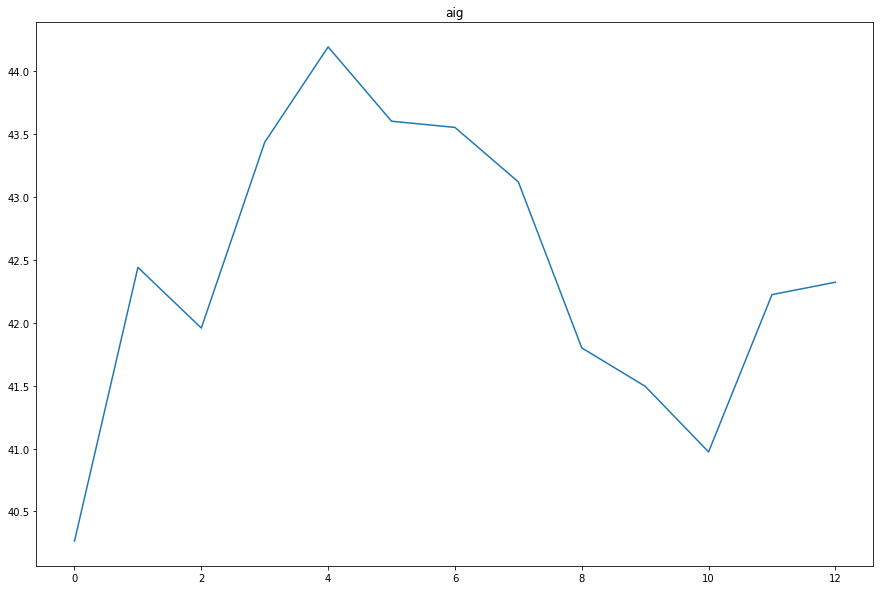

In [305]:
plot('aig',Dict_,'Close',22,34)

# Baseline Model

A toy test on monthly rebalance:

In [302]:
#Rebalance Times
Dict_['a']['Date'][11],Dict_['a']['Date'][23],Dict_['a']['Date'][34],Dict_['a']['Date'][44],Dict_['a']['Date'][53],Dict_['a']['Date'][62]

('20181016', '20181101', '20181116', '20181203', '20181217', '20181231')

In [6]:
#Select stocks that have the highest historical returns
pool_past={}
macd_past={}
pool_cur={}
macd_cur={}
pool_future={}
for name in Dict_.keys():
    #print(name)
    cur=Dict_[name]
    C=np.array(cur['Close'])
    O=np.array(cur['Open'])
    macd=np.array(cur['MACD'])
    past=(C[22]-O[0])/O[0]
    cur=(C[43]-O[23])/O[23]
    future=(C[62]-O[44])/O[44]
    pool_past[name]=past
    macd_past[name]=macd[22]
    pool_cur[name]=cur
    macd_cur[name]=macd[43]
    pool_future[name]=future

In [7]:
s=30
dd = sorted(pool_past.items(), key=lambda x: x[1],reverse=True)
pool1=[pair[0] for pair in dd[s:2*s] if pair[1]>0 and macd_past[pair[0]]>0]
performance=sum([pool_cur[n] for n in pool1])/float(s)
benchmark=sum(pool_cur.values())/len(pool_cur.keys())

In [8]:
benchmark,performance

(0.016282695755074406, 0.040392785764703135)

In [9]:
print(pool1)

['mcd', 'hsy', 'tup', 'sjm', 'hcp', 'xlnx', 'atge', 'uaa', 'exr', 'f', 'spg', 'iff', 'etr', 'aep', 'ko', 'mrk', 'dltr', 'hrb', 'duk', 'scg', 'mmc', 'xrx', 'cmg', 'ice']


In [10]:
#Phase 2
dd = sorted(pool_cur.items(), key=lambda x: x[1],reverse=True)
pool2=[pair[0] for pair in dd[s:2*s] if pair[1]>0 and macd_cur[pair[0]]>0]
performance=sum([pool_future[n] for n in pool2])/float(s)
benchmark=sum(pool_future.values())/len(pool_future.keys())

In [11]:
print(pool2)

['ghc', 'swk', 'see', 'uhs', 'mxim', 'dal', 'ehc', 'mlm', 'a', 'sci', 'aap', 'cmi', 'adsk', 'pwr', 'mdp', 'gnw', 'luv', 'clx', 'cvs', 'lrcx', 'dhr', 'xyl', 'cat', 'kmb', 'gww', 'aiv', 'ben']


In [12]:
benchmark,performance

(-0.12438698218471632, -0.09595958688856768)

We see that by selecting conservatively the second top tier stocks (size 20 and historic return positive) in the total 601 stocks that performed best in the respective test months
we usually get w pool that performs better than the baseline market average returns. For the month 11.01-11.31 we have a return of 0.0404 over 0.0163. For the month 12.03-12.31
we have a return of -0.096 over -0.1244. When selecting stocks we also add in a criterion that MACD values at the rebalance point must be positive for
us to add the stock into our buy long portfolio.


### Testing on Semi-monthly rebalance 

In [13]:
#Rebalance Times
testdates=[[Dict_['a']['Date'][11],Dict_['a']['Date'][22]]
           ,[Dict_['a']['Date'][23],Dict_['a']['Date'][33]]
           ,[Dict_['a']['Date'][34],Dict_['a']['Date'][43]]
           ,[Dict_['a']['Date'][44],Dict_['a']['Date'][52]]
           ,[Dict_['a']['Date'][53],Dict_['a']['Date'][62]]]

In [16]:
#Gather Test Period Data
pool_p1={}
macd_p1={}
pool_p2={}
macd_p2={}
pool_p3={}
macd_p3={}
pool_p4={}
pool_p5={}
pool_p6={}
macd_p4={}
macd_p5={}
macd_p6={}
for name in Dict_.keys():
    #print(name)
    cur=Dict_[name]
    C=np.array(cur['Close'])
    O=np.array(cur['Open'])
    macd=np.array(cur['MACD'])
    pool_p1[name]=(C[10]-O[0])/O[0]
    macd_p1[name]=macd[10]
    pool_p2[name]=(C[22]-O[11])/O[11]
    macd_p2[name]=macd[22]
    pool_p3[name]=(C[33]-O[23])/O[23]
    macd_p3[name]=macd[33]
    pool_p4[name]=(C[43]-O[34])/O[34]
    macd_p4[name]=macd[43]
    pool_p5[name]=(C[52]-O[44])/O[44]
    macd_p5[name]=macd[52]
    pool_p6[name]=(C[62]-O[53])/O[53]
    

Naive MACD Baseline

In [17]:
#Testing Result
s=30
P=[pool_p1,pool_p2,pool_p3,pool_p4,pool_p5,pool_p6]
M=[macd_p1,macd_p2,macd_p3,macd_p4,macd_p5,macd_p6]
for i in range(5):
    dd = sorted(P[i].items(), key=lambda x: x[1],reverse=True)
    pool1=[pair[0] for pair in dd[s:2*s] if pair[1]>0 and M[i][pair[0]]>0]
    performance=sum([P[i+1][n] for n in pool1])/float(s)
    benchmark=sum(P[i+1].values())/len(P[i+1].keys())
    print(benchmark,performance)

-0.02377470308569231 0.008416277793983176
0.00958486895368256 0.009895974212731584
0.008820059157016264 0.008668956915780204
-0.08420009378968411 -0.0790157009478927
-0.04260201275399443 -0.03327840588916


# NN Model

With a Neural Network with only fully connected layers we can pass in the entire historic indicator values and returns over the past 14 days (10 trading days) and predict this future period return accordingly.
The predicted returns will be used in place of the historic returns to select the top N stocks aggressively and test using the same time periods.
We still only select stocks that have a positive predicted returns. 

### Semi-monthly Rebalance

Gathering training and testing data

In [73]:
from keras.models import Sequential
from keras.layers import Dense
data=[]
p1=[]
p2=[]
p3=[]
p4=[]
p5=[]
for name in Dict_.keys():
    cur=Dict_[name]
    C=np.array(cur['Close'])
    h=10
    for i in range(h,len(C)-h):
        vec=[]
        for j in ['EMA','MACD','SMI','SO','RSI','Close']:
            vec+=list(np.array(cur[j])[i-h+1:i+1])
        #vec.append((C[i]-C[i-h])/C[i-h])
        vec.append((C[i+h]-C[i])/C[i])
        if i!=52:
            data.append(vec)
        if i==10:
            p1.append(vec[:-1])
        elif i==22:
            p2.append(vec[:-1])
        elif i==33:
            p3.append(vec[:-1])
        elif i==43:
            p4.append(vec[:-1])
        elif i==52:
            p5.append(vec[:-1])
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data=np.array(data)
#data=scaler.fit_transform(data)
np.random.shuffle(data)
size=int(0.8*len(data))
X_train=data[0:size,0:-1]
y_train=data[0:size,-1]
X_test=data[size:,0:-1]
y_test=data[size:,-1]



Building Neural Network 1

In [90]:
#Bulding Neural Network
model_2 = Sequential()
model_2.add(Dense(100, input_dim=X_train.shape[1], activation='sigmoid'))
model_2.add(Dense(20,activation='sigmoid'))
model_2.add(Dense(1))

model_2.compile(loss='mean_squared_error', optimizer='adam')

In [91]:

history=model_2.fit(X_train,y_train,validation_split=0.2,epochs=150,batch_size=1000,verbose=1)

Train on 16154 samples, validate on 4039 samples
Epoch 1/150
16154/16154 [==============================] - 0s 27us/step - loss: 0.3480 - val_loss: 0.1033
Epoch 2/150
16154/16154 [==============================] - 0s 5us/step - loss: 0.0439 - val_loss: 0.0142
Epoch 3/150
16154/16154 [==============================] - 0s 6us/step - loss: 0.0133 - val_loss: 0.0090
Epoch 4/150
16154/16154 [==============================] - 0s 8us/step - loss: 0.0090 - val_loss: 0.0084
Epoch 5/150
16154/16154 [==============================] - 0s 7us/step - loss: 0.0081 - val_loss: 0.0081
Epoch 6/150
16154/16154 [==============================] - 0s 6us/step - loss: 0.0078 - val_loss: 0.0079
Epoch 7/150
16154/16154 [==============================] - 0s 5us/step - loss: 0.0076 - val_loss: 0.0077
Epoch 8/150
16154/16154 [==============================] - 0s 6us/step - loss: 0.0074 - val_loss: 0.0075
Epoch 9/150
16154/16154 [==============================] - 0s 6us/step - loss: 0.0072 - val_loss: 0.0074
Epoch

In [92]:
model_2.evaluate(X_test,y_test)

5049/5049 [==============================] - 0s 22us/step


0.005916354044641769

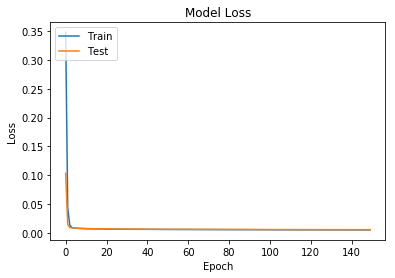

In [95]:

# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


Recall the baseline model

In [432]:
s=30
print('Period                 Index                      Benchmark')
P=[pool_p1,pool_p2,pool_p3,pool_p4,pool_p5,pool_p6]
M=[macd_p1,macd_p2,macd_p3,macd_p4,macd_p5,macd_p6]
f=open('benchmark model.txt','w')

for i in range(5):
    period=testdates[i][0]+'-'+testdates[i][1]
    dd = sorted(P[i].items(), key=lambda x: x[1],reverse=True)
    pool1=[pair[0] for pair in dd[s:2*s] if pair[1]>0 and M[i][pair[0]]>0]
    
    performance=sum([P[i+1][n] for n in pool1])/float(s)
    benchmark=sum(P[i+1].values())/len(P[i+1].keys())
    print(period,benchmark,performance)
    print(pool1)
    f.write(period+' '+str(benchmark)+' '+str(performance))
    f.write('\n')
    f.write(' '.join(pool1)+'\n')
f.close()

Period                 Index                      Benchmark
20181016-20181031 -0.019325422149862357 0.000422169404690497
['rdc', 'sre', 'gis', 'd', 'wec', 'nee', 'azo', 'so', 'cnx', 'peg', 'xel', 'kdp', 'eix', 'evrg', 'etr']
20181101-20181115 0.0070728061643819985 -0.00221331815813595
['dg', 'cmcsa', 'cien', 'iff', 'pypl', 'vtr', 'sbac', 'cinf', 'ndaq', 'hrl', 'atge', 'xrx', 'grmn', 'cnx', 'ncr', 'igt', 'spg', 'ntap', 'cmg', 'phm', 'mmc', 'mkc', 'mcd', 'kr', 'vz', 'anf', 'ice', 'cbs']
20181116-20181130 0.022094647840201428 0.015266229147498823
['swk', 'ghc', 'fl', 'fast', 'azo', 'cien', 'ash', 'itt', 'expd', 'mlm', 'rrc', 'gnw', 'alk', 'pnw', 'car', 'pxd', 'clx', 'evrg', 'pwr', 'oxy', 'ame', 'vrsn', 'dlx', 'o', 'ehc', 'nrg', 'cmi', 'ir', 'hog']
20181203-20181214 -0.08546675310343232 -0.10246263532774673
['alk', 'pbct', 'uaa', 'amgn', 'len', 'tex', 'cat', 'coo', 'sanm', 'holx', 'ben', 'qcom', 'regn', 'dhr', 'sivb', 'mnst', 'pcg', 'mxim', 'tgna', 'pki', 'ilmn', 'ncr', 'tmo', 'pfe', 'adbe

Long Only top 10 NN1 Portfolio

NN Balanced corresponds to an equal weight portfolio, NN Weighted corresponds to an aggressive portfolio

In [433]:
P=[pool_p1,pool_p2,pool_p3,pool_p4,pool_p5,pool_p6]
H=[p1,p2,p3,p4,p5]
Long=[]
s=10
f=open('top'+str(s)+'_nn_model1.txt','w')
print('Period                  Index                NN Balanced                  NN Weighted')
for i in range(5):
    period=testdates[i][0]+'-'+testdates[i][1]
    pool_pred={}
    y_pred=model_2.predict(np.array(H[i]))
    for j in range(len(Dict_.keys())):
        pool_pred[list(Dict_.keys())[j]]=y_pred[j]
  
    dd = sorted(pool_pred.items(), key=lambda x: x[1],reverse=True)
    pool=[pair[0] for pair in dd[0:s] if pair[1]>0]
    mu=[pair[1][0] for pair in dd[0:s] if pair[1]>0]
    Long.append((pool,mu))
    performance=sum([P[i+1][n] for n in pool])/float(len(pool))
    performance2=sum([P[i+1][n]*pool_pred[n][0] for n in pool])/float(np.sum(mu));
    benchmark=sum(P[i+1].values())/len(P[i+1].keys())
    print(period,benchmark,performance,performance2)
    f.write(period+' '+str(benchmark)+' '+str(performance)+' '+str(performance2))
    f.write('\n')
    f.write(' '.join(pool)+'\n')
    print(pool)
f.close()

Period                  Index                NN Balanced                  NN Weighted
20181016-20181031 -0.019325422149862357 0.04411613080438058 0.053351732923220964
['kim', 'ivz', 'ctb', 'dre', 'anf', 'pbi', 'spxc', 'nav', 'nyt', 'jbl']
20181101-20181115 0.0070728061643819985 0.04253682576617092 0.04337058318070377
['nktr', 'aig', 'amd', 'luv', 'pch', 'wdc', 'nclh', 'celg', 'dwdp', 'spxc']
20181116-20181130 0.022094647840201428 0.023111861432812467 0.024654486480195914
['avp', 'uaa', 'atvi', 'odp', 'bk', 'nov', 'dlx', 'ice', 'nav', 'cog']
20181203-20181214 -0.08546675310343232 -0.03235052030874601 -0.03835868323897019
['cag', 'mo', 'hp', 'peg', 'pcar', 'eix', 'ice', 'rsg', 'dnb', 'abbv']
20181217-20181231 -0.04260201275399443 -0.04587041190404334 -0.04510268605383039
['tjx', 'sig', 'fti', 'sanm', 'apc', 'ms', 'cbs', 'car', 'nov', 'tif']


Performance of the Long and Short portfolio

In [434]:
P=[pool_p1,pool_p2,pool_p3,pool_p4,pool_p5,pool_p6]
H=[p1,p2,p3,p4,p5]
print('Index                     NN L&S')
f=open('top'+str(s)+'_nn_model1_ls.txt','w')
for i in range(5):
    period=testdates[i][0]+'-'+testdates[i][1]
    pool_pred={}
    y_pred=model_2.predict(np.array(H[i]))
    for j in range(len(Dict_.keys())):
        pool_pred[list(Dict_.keys())[j]]=y_pred[j]
    
    dd = sorted(pool_pred.items(), key=lambda x: x[1],reverse=True)
    pool_l=[pair[0] for pair in dd[0:s] if pair[1]>0]
    pool_s=[pair[0] for pair in dd[-s:] if pair[1]<0]
    #print('Long:')
    #print(pool_l)
    #print('Short:')
    #print(pool_s)
    performance=(-sum([P[i+1][n] for n in pool_s])+sum([P[i+1][n] for n in pool_l]))/float(len(pool_l)+len(pool_s))
    benchmark=sum(P[i+1].values())/len(P[i+1].keys())
    print(benchmark,performance)
    f.write(period+' '+str(benchmark)+' '+str(performance))
    f.write('\n')
    f.write('Long:'+' '.join(pool_l)+'\n')
    f.write('Short:'+' '.join(pool_s)+'\n')
f.close()

Index                     NN L&S
-0.019325422149862357 0.12508586425940046
0.0070728061643819985 0.10040878206089328
0.022094647840201428 0.05543243539281758
-0.08546675310343232 0.07281330209033185
-0.04260201275399443 0.01812137434853094


Another model with different architecture: NN Model 2

In [351]:
data2=[]
q1=[]
q2=[]
q3=[]
q4=[]
q5=[]
for name in Dict_.keys():
    cur=Dict_[name]
    C=np.array(cur['Close'])
    h=11
    for i in range(h-1,len(C)-10):
        vec=[]
        for j in ['EMA','MACD','SMI','SO','RSI','Close']:
            vec+=list(np.array(cur[j])[i-h+1:i+1])
        #vec.append((C[i]-C[i-h])/C[i-h])
        vec.append((C[i+10]-C[i])/C[i])
        if i!=52:
            data2.append(vec)
        if i==10:
            q1.append(vec[:-1])
        elif i==22:
            q2.append(vec[:-1])
        elif i==33:
            q3.append(vec[:-1])
        elif i==43:
            q4.append(vec[:-1])
        elif i==52:
            q5.append(vec[:-1])
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data2=np.array(data2)
np.random.shuffle(data2)
size=int(0.8*len(data2))
y_train2=data2[0:size,-1]
y_test2=data2[size:,-1]
#data_=scaler.fit_transform(data2)


X_train2=data2[0:size,0:-1]

X_test2=data2[size:,0:-1]




In [360]:
#Training Neural Network
model_3 = Sequential()
model_3.add(Dense(100, input_dim=X_train2.shape[1], activation='sigmoid'))
model_3.add(Dense(60,activation='relu'))
model_3.add(Dense(20,activation='sigmoid'))
model_3.add(Dense(1))

model_3.compile(loss='mean_squared_error', optimizer='adam')

In [361]:
history=model_3.fit(X_train2,y_train2,validation_split=0.2,epochs=100,batch_size=1000,verbose=1)

Train on 16154 samples, validate on 4039 samples
Epoch 1/100
16154/16154 [==============================] - 3s 171us/step - loss: 0.1876 - val_loss: 0.0251
Epoch 2/100
16154/16154 [==============================] - 0s 15us/step - loss: 0.0153 - val_loss: 0.0093
Epoch 3/100
16154/16154 [==============================] - 0s 12us/step - loss: 0.0082 - val_loss: 0.0069
Epoch 4/100
16154/16154 [==============================] - 0s 11us/step - loss: 0.0069 - val_loss: 0.0066
Epoch 5/100
16154/16154 [==============================] - 0s 12us/step - loss: 0.0065 - val_loss: 0.0065
Epoch 6/100
16154/16154 [==============================] - 0s 13us/step - loss: 0.0063 - val_loss: 0.0064
Epoch 7/100
16154/16154 [==============================] - 0s 12us/step - loss: 0.0062 - val_loss: 0.0063
Epoch 8/100
16154/16154 [==============================] - 0s 12us/step - loss: 0.0061 - val_loss: 0.0062
Epoch 9/100
16154/16154 [==============================] - 0s 11us/step - loss: 0.0061 - val_loss: 0.0

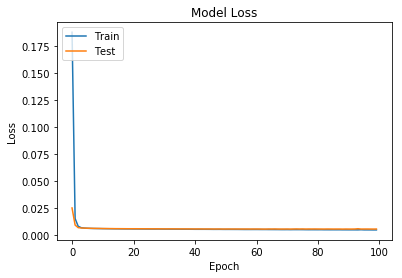

In [362]:
#Model Loss History
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [364]:
#Testing MSE
model_3.evaluate(X_test2,y_test2)

5049/5049 [==============================] - 0s 87us/step


0.005448024920365891

NN Model 2 Results

In [435]:
P=[pool_p1,pool_p2,pool_p3,pool_p4,pool_p5,pool_p6]
H2=[q1,q2,q3,q4,q5]
Long=[]
s=10
f=open('top'+str(s)+'_nn_model2.txt','w')
print('Period              Index                NN Balanced                  NN Weighted')
for i in range(5):
    period=testdates[i][0]+'-'+testdates[i][1]
    pool_pred={}
    y_pred=model_3.predict(np.array(H2[i]))
    for j in range(len(Dict_.keys())):
        pool_pred[list(Dict_.keys())[j]]=y_pred[j]
    
    dd = sorted(pool_pred.items(), key=lambda x: x[1],reverse=True)
    pool=[pair[0] for pair in dd[0:s] if pair[1]>0]
    mu=[pair[1][0] for pair in dd[0:s] if pair[1]>0]
    Long.append((pool,mu))
    performance=sum([P[i+1][n] for n in pool])/float(len(pool))
    performance2=sum([P[i+1][n]*pool_pred[n][0] for n in pool])/float(np.sum(mu));
    benchmark=sum(P[i+1].values())/len(P[i+1].keys())
    print(period,benchmark,performance,performance2)
    f.write(period+' '+str(benchmark)+' '+str(performance)+' '+str(performance2)+'\n')
    f.write(' '.join(pool)+'\n')
f.close()

Period              Index                NN Balanced                  NN Weighted
20181016-20181031 -0.019325422149862357 0.025246106631638742 0.03160816240859255
20181101-20181115 0.0070728061643819985 0.059076495525262604 0.06208644293843664
20181116-20181130 0.022094647840201428 0.05255581208378239 0.05804721722958122
20181203-20181214 -0.08546675310343232 -0.0666680450971471 -0.05780509929657505
20181217-20181231 -0.04260201275399443 -0.03452686674023196 -0.03241343488984187


Long Short Performance

In [436]:
f=open('top'+str(s)+'_nn_model2_ls.txt','w')
print('Period               Index                     NN L&S')
for i in range(5):
    pool_pred={}
    period=testdates[i][0]+'-'+testdates[i][1]
    y_pred=model_3.predict(np.array(H2[i]))
    for j in range(len(Dict_.keys())):
        pool_pred[list(Dict_.keys())[j]]=y_pred[j]
    dd = sorted(pool_pred.items(), key=lambda x: x[1],reverse=True)
    pool_l=[pair[0] for pair in dd[0:s] if pair[1]>0]
    pool_s=[pair[0] for pair in dd[-s:] if pair[1]<0]
    #print('Long:')
    #print(pool_l)
    #print('Short:')
    #print(pool_s)
    performance=(-sum([P[i+1][n] for n in pool_s])+sum([P[i+1][n] for n in pool_l]))/float(len(pool_l)+len(pool_s))
    benchmark=sum(P[i+1].values())/len(P[i+1].keys())
    
    f.write(period+' '+str(benchmark)+' '+str(performance)+'\n')
    f.write('Long:'+' '.join(pool_l)+'\n')
    f.write('Short:'+' '.join(pool_s)+'\n')
    print(period,benchmark,performance)
f.close()

Period               Index                     NN L&S
20181016-20181031 -0.019325422149862357 0.09234298365717084
20181101-20181115 0.0070728061643819985 0.07581653683039476
20181116-20181130 0.022094647840201428 0.06903401680976498
20181203-20181214 -0.08546675310343232 0.06273192366831629
20181217-20181231 -0.04260201275399443 0.050071398852771565


### Ensembling Two Neural Network Models to Create a Consensus Portfolio 

From previous tuning of parameter s which stands for N in the portfolio scope, we conclude that a portfolio with 10 stocks generally outperforms
the portfolio with 20 stocks or 30 stocks. It is an evidence towards the efficient predictions of our neural network models.

For the ensembled model we select the top 5 stocks returned by each neural network model. Consensus stocks will be given twice the weight.

In [437]:
#Consensus Model Results
P=[pool_p1,pool_p2,pool_p3,pool_p4,pool_p5,pool_p6]
H2=[q1,q2,q3,q4,q5]
s=5
f=open('top'+str(s)+'_nn_model_combined.txt','w')
print('Period              Index                NN Balanced')
for i in range(5):
    period=testdates[i][0]+'-'+testdates[i][1]
    pool_pred={}
    pool_pred2={}
    y_pred=model_3.predict(np.array(H2[i]))
    y_p=model_2.predict(np.array(H[i]))
    for j in range(len(Dict_.keys())):
        pool_pred[list(Dict_.keys())[j]]=y_pred[j]
    for j in range(len(Dict_.keys())):
        pool_pred2[list(Dict_.keys())[j]]=y_p[j]
    dd = sorted(pool_pred.items(), key=lambda x: x[1],reverse=True)
    dd2 = sorted(pool_pred2.items(), key=lambda x: x[1],reverse=True)
    pool=[pair[0] for pair in dd[0:s] if pair[1]>0]+[pair[0] for pair in dd2[0:s] if pair[1]>0]
    
    performance=sum([P[i+1][n] for n in pool])/float(len(pool))
    
    benchmark=sum(P[i+1].values())/len(P[i+1].keys())
    print(period,benchmark,performance)
    f.write(period+' '+str(benchmark)+' '+str(performance)+'\n')
    f.write(' '.join(pool)+'\n')
f.close()

Period              Index                NN Balanced
20181016-20181031 -0.019325422149862357 0.0871295128075463
20181101-20181115 0.0070728061643819985 0.0573194618965332
20181116-20181130 0.022094647840201428 0.054454408482617775
20181203-20181214 -0.08546675310343232 -0.047902284814382155
20181217-20181231 -0.04260201275399443 -0.037832105533962726


Mixed Long and Short

In [438]:
f=open('top'+str(s)+'_nn_model_combined_ls.txt','w')
print('Period               Index                     NN L&S')
for i in range(5):
    pool_pred={}
    pool_pred2={}
    period=testdates[i][0]+'-'+testdates[i][1]
    
    y_pred=model_3.predict(np.array(H2[i]))
    y_p=model_2.predict(np.array(H[i]))
    for j in range(len(Dict_.keys())):
        pool_pred[list(Dict_.keys())[j]]=y_pred[j]
    for j in range(len(Dict_.keys())):
        pool_pred2[list(Dict_.keys())[j]]=y_p[j]
    dd = sorted(pool_pred.items(), key=lambda x: x[1],reverse=True)
    dd2 = sorted(pool_pred2.items(), key=lambda x: x[1],reverse=True)
    pool_l=[pair[0] for pair in dd[0:s] if pair[1]>0]+[pair[0] for pair in dd2[0:s] if pair[1]>0]
    
    pool_s=[pair[0] for pair in dd[-s:] if pair[1]<0]+[pair[0] for pair in dd2[-s:] if pair[1]<0]
    #print('Long:')
    #print(pool_l)
    #print('Short:')
    #print(pool_s)
    performance=(-sum([P[i+1][n] for n in pool_s])+sum([P[i+1][n] for n in pool_l]))/float(len(pool_l)+len(pool_s))
    benchmark=sum(P[i+1].values())/len(P[i+1].keys())
    
    f.write(period+' '+str(benchmark)+' '+str(performance)+'\n')
    f.write('Long:'+' '.join(pool_l)+'\n')
    f.write('Short:'+' '.join(pool_s)+'\n')
    print(period,benchmark,performance)
f.close()

Period               Index                     NN L&S
20181016-20181031 -0.019325422149862357 0.185284257802021
20181101-20181115 0.0070728061643819985 0.10859354302026736
20181116-20181130 0.022094647840201428 0.09440077739390537
20181203-20181214 -0.08546675310343232 0.0719299784372482
20181217-20181231 -0.04260201275399443 0.05636809481864834


So far we have considered various models and portfolio choices, for the rest of the transaction cost analysis we will stick with the best performing
portfolio: top 5 NN Model Combined. The results have been saved into text files for easy access. In particular, we analyze long only portfolios and how the execution prices differ from decision prices.